## TensorFlow Basics
<a name="basics"></a>
Let us have a look at the key differences between TensorFlow and other numerical computation library NumPy. One of the main differences is that operations in TensorFlow are nodes in the TF graph and are symbolic. The reason for this is that it allows TensorFlow to do automatic differentiation for the given operation at the backend and also save some computation steps. This is not possible or required with imperative libraries like NumPy. The automatic differentiation speeds up backpropogation, which is a key step in neural networks training. 

The downside of this is that it becomes slightly harder to grasp. We'll try and demystify TF in this session. We'll also lay down some guidelines and best practices for more effective use of TensorFlow.

In [1]:
# Import required libraries
import tensorflow as tf
import numpy as np

Let's start with a simple example. Let's say we want to multiply two random matrices x and y of size $3 \times 10$ and $10 \times 3$ to get a $3 \times 3$ matrix. First let's have a look at an implementation done in NumPy:

In [2]:
x = np.random.normal(size=[3, 10])
y = np.random.normal(size=[10, 3])
z = np.dot(x, y)

print(z)

[[ 2.6295333  -5.92586833  0.12559209]
 [-0.61678362 -0.79804005  0.09345273]
 [ 1.2839981   0.18523983  1.92608881]]


Now we perform the exact same computation this time in TensorFlow:

In [3]:
tf.reset_default_graph()

x = tf.random_normal([3, 10])
y = tf.random_normal([10, 3])
z = tf.matmul(x, y)

Unlike NumPy that immediately performs the computation and produces the result, tensorflow only gives us a handle (of type Tensor) to a node in the graph that represents the result. So, basically it created a graph in which x and y are nodes and so is MatMul. The output of Matmul is a Tensor z. Let us look at z

In [4]:
z

<tf.Tensor 'MatMul:0' shape=(3, 3) dtype=float32>

Since both the inputs have a fully defined shape, tensorflow is able to infer the shape of the tensor as well as its type. To compute the value of the tensor we need to create a session and evaluate it using Session.run() method. But first let us better understand TensorFlow Graphs and Sessions

In [5]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [6]:
show_graph(tf.get_default_graph().as_graph_def())

## Graphs and Sessions ##
Tensorflow represents computations as nodes in a dataflow graph where the data is moving across nodes in the form of tensors. The computational graph, thus also contains information about the dependencies between nodes. Using a dataflow graph has several advantages

__Parallelism__: It is very easy for the system to identify operations that can execute in parallel.<br>
__Distributed execution__: It is possible for TensorFlow to partition your program across multiple devices (CPUs, GPUs, and TPUs) attached to different machines, which is mostly does. TensorFlow inserts the necessary communication and coordination between devices. <br>

__Portability__: The dataflow graph is a language-independent representation of the code in your model and hence easily portable <br>

So, we saw that the graph defines the computation. But, also know that it doesn’t actually compute anything nor does it hold any values. It simply specifies the operations as per the code. to actually run the operations in the graph, you need session.

Session allows execution of graphs or even part of graphs. It determines the part of the graph which will be required to compute the output given the specified inputs. Based on this, it allocates the resources (on one or more machines) for that. The session will also allocate memory to store the current value of the variable. It also contains the actual values of intermediate results and the output variables.

Let us take a look at how we can use Session to compute output z.

In [7]:
sess = tf.Session()
z_val = sess.run(z)

print(z_val)

[[ 1.58613467  2.02158689 -0.86394453]
 [-4.15483713  2.59027386  4.21101952]
 [-0.36584878 -3.23801374  6.9401269 ]]


Variables in TensorFlow need to be initialized and then they change values as per the operations applied on them in the graph.

In [8]:
variable = tf.Variable(42, name='foo')
init = tf.global_variables_initializer()
assign = variable.assign(13)

with tf.Session(graph=tf.get_default_graph()) as sess:
  sess.run(init)
  print(sess.run(variable))
  sess.run(assign)
  print(sess.run(variable))

42
13


Variables in TensorFlow need to be initialized and then they change values as per the operations applied on them in the graph.

In [9]:
with tf.Session(graph=tf.get_default_graph()) as sess:
   print("Uncomment to see error") 
   #print(sess.run(variable)) # Uncomment and you can see the variable unitialized error

Uncomment to see error


## PlaceHolders ##

Apart from variables, TensorFlow has PlaceHolders. They are similar to variables in that they are used to store values and are a basic data structure. A placeholder can be best thought of as a variable to which data has not been assigned and we'll the assign data at a later date. It allows us to create our operations and build our computation graph, without needing the data. 

The use case will become more clear when we use it in Neural nets. In TensorFlow terminology, data is fed into the graph through these placeholders. The data to be passed in into the placeholder is passed in as a dictionary, where key is the Tensor set as Placeholder and value is the data to be fed into it. Let us look at a small example:

In [10]:
x = tf.placeholder("float", None)
y = x * 2

with tf.Session() as session:
    result = session.run(y, feed_dict={x: [1, 2, 3]})
    print(result)

[ 2.  4.  6.]


***
__Important Note:__: When using Jupyter notebook we need to make sure to call tf.reset_default_graph() at the beginning to clear the symbolic graph before defining new nodes. Else older nodes will not be cleared. 
***

## Power of symbolic computation in TF ##

Next, let us have a look at how TensorFlow can be best utlized for symbolic computation. We'll look at the example of a simple queadratic curve. So, we have some points which lie on a quadratic curve and we would like to determine the coefficients of this $2^{nd}$ degree polynomial.  To understand how powerful symbolic computation can be let uss have a look at the example. Assumingat we have samples from the $2^{nd}$ degree polynomial curve 
$f(x) = 2x^2 + 3x + 1 $
and we want to estimate $f(x)$ based on these samples. 

This is common practice in Machine Learning - curve fitting, or trying to find true values of parameters for a given parametric function.  In this current case, the parametric function is 
$g(x, w) = w_0 x^2 + w_1 x + w_2$,
which is a function of the input x and unknown parameters w. Our goal is then to find the parameters such that $g(x, w) ≈ f(x)$, or if the points are not exactly on the curve, we try to find the best appromiation, i.e.
\begin{equation}
loss = || g(x,w) - f(x,w) || ^2 
\end{equation}

we try to minimize this loss over all possible values of $w$.

This can be done by minimizing the following loss function: $L(w) = \sum (f(x) - g(x, w))^2$. Although there's a closed form solution for this simple problem, we opt to use a more general approach that can be applied to any arbitrary differentiable function using stochastic gradient descent. We simply compute the average gradient of L(w) with respect to w over a set of sample points and move in the opposite direction. This gets us to the bottom of the curve where the loss value is minimized and we have the correct parameters.

Here's how it can be done in TensorFlow:

In [11]:
tf.reset_default_graph()

# Placeholders are used to feed values from python to TensorFlow ops. We define
# two placeholders, one for input feature x, and one for output y.
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

# Assuming we know that the desired function is a polynomial of 2nd degree, we
# allocate a vector of size 3 to hold the coefficients. The variable will be
# automatically initialized with random noise.
w = tf.get_variable("w", shape=[3, 1])

# We define yhat to be our estimate of y.
f = tf.stack([tf.square(x), x, tf.ones_like(x)], 1)
yhat = tf.squeeze(tf.matmul(f, w), 1)

# The loss is defined to be the l2 distance between our estimate of y and its
# true value. We also added a shrinkage term, to ensure the resulting weights
# would be small.
loss = tf.losses.mean_squared_error(yhat, y) #+ 0.1 * tf.nn.l2_loss(w)

# We use the Adam optimizer with learning rate set to 0.1 to minimize the loss.
# Not to worry if you know nothing about Adam Optimizer as of now- it's a method of 
# moving from a given starting point in a curve to the minima using the 
# gradient values at each point 
train_op = tf.train.AdamOptimizer(0.1).minimize(loss)

def generate_data():
    x_val = np.random.uniform(-10.0, 10.0, size=10000)
    y_val = 2 * np.square(x_val) + 3 * x_val + 1
    return x_val, y_val

sess = tf.Session()
# Since we are using variables we first need to initialize them.
sess.run(tf.global_variables_initializer())

num_epochs = 500
loss_arr = np.zeros((num_epochs,1))
w_arr = np.zeros((num_epochs,3))
x_val, y_val = generate_data()
for i in range(num_epochs):
    _, loss_val, w_val = sess.run([train_op, loss,w], {x: x_val, y: y_val})
    loss_arr[i,0] = loss_val
    w_arr[i,:] = w_val[:,0]

    #print(loss_val)
print(sess.run([w]))

[array([[ 1.99915993],
       [ 2.99998236],
       [ 1.04920447]], dtype=float32)]


As can be seen we get results quite close to the true values [2,3,1]. 

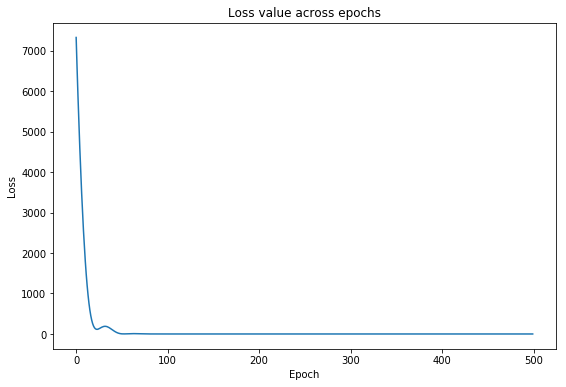

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize = [9,6])
plt.plot(loss_arr)
plt.title('Loss value across epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

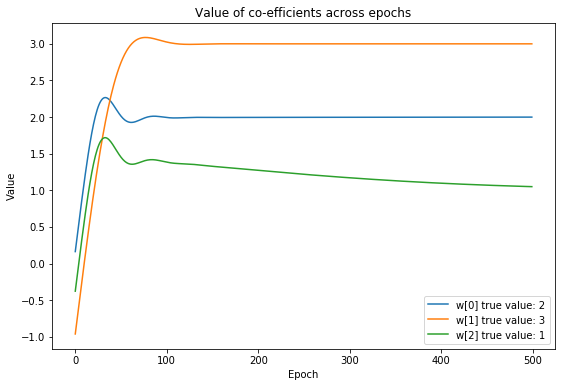

In [13]:
plt.figure(figsize = [9,6])
plt.plot(w_arr[:,0])
plt.plot(w_arr[:,1])
plt.plot(w_arr[:,2])
plt.legend(['w[0] true value: 2', 'w[1] true value: 3','w[2] true value: 1'])
plt.title('Value of co-efficients across epochs')
plt.ylabel('Value')
plt.xlabel('Epoch')

This is just tip of the iceberg for what TensorFlow can do. Many problems such as optimizing large neural networks with millions of parameters can be implemented efficiently in TensorFlow in just a few lines of code. TensorFlow takes care of scaling across multiple devices, and threads, and supports a variety of platforms.

## Understanding static and dynamic shapes
<a name="shapes"></a>
Tensors in TensorFlow have a static shape attribute which is determined during graph construction. The static shape
may be underspecified. For example we might define a tensor of shape [None, 128]:


In [14]:
tf.reset_default_graph()
a = tf.placeholder(tf.float32, [None, 128])

This means that the first dimension can be of any size and will be determined dynamically during Session.run().
You can query the static shape of a Tensor as follows:

In [15]:
static_shape = a.shape.as_list()  
print(static_shape) # returns [None, 128]

[None, 128]


To get the dynamic shape of the tensor you can call tf.shape op, which returns a tensor 
representing the shape of the given tensor:

In [16]:
dynamic_shape = tf.shape(a)
print(dynamic_shape)

Tensor("Shape:0", shape=(2,), dtype=int32)


In [17]:
sess = tf.InteractiveSession()
sess.run(dynamic_shape, {a:np.random.randn(110,128)})

array([110, 128], dtype=int32)

The static shape of a tensor can be set with Tensor.set_shape() method:

In [18]:
a.set_shape([32, 128])  # static shape of a is [32, 128]
print(a.shape.as_list())
a.set_shape([None, 128])  # first dimension of a is determined dynamically

[32, 128]


You can reshape a given tensor dynamically using tf.reshape function:

In [19]:
a =  tf.reshape(a, [128, 32])
print(a.shape.as_list())

[128, 32]


It can be convenient to have a function that returns the static shape when available and 
dynamic shape when it's not. The following utility function does just that:

In [20]:
def get_shape(tensor):
  static_shape = tensor.shape.as_list()
  dynamic_shape = tf.unstack(tf.shape(tensor))
  dims = [s[1] if s[0] is None else s[0]
          for s in zip(static_shape, dynamic_shape)]
  return dims

print(get_shape(a))

[128, 32]


Now imagine we want to convert a Tensor of rank 3 to a tensor of rank 2 by collapsing the second 
and third dimensions into one. We can use our get_shape() function to do that:

In [21]:
b = tf.placeholder(tf.float32, [None, 64, 32])
shape = get_shape(b)
print(shape)
b = tf.reshape(b, [shape[0], shape[1] * shape[2]])

[<tf.Tensor 'unstack_1:0' shape=() dtype=int32>, 64, 32]


Note that this works whether the shapes are statically specified or not.<br>
__ Student Exercise__: write a general purpose reshape function to collapse any list of dimensions:

In [22]:
def reshape(tensor, dims_list):
  shape = get_shape(tensor)
  dims_prod = []
  for dims in dims_list:
    if isinstance(dims, int):
      dims_prod.append(shape[dims])
    elif all([isinstance(shape[d], int) for d in dims]):
      dims_prod.append(np.prod([shape[d] for d in dims]))
    else:
      dims_prod.append(tf.prod([shape[d] for d in dims]))
  tensor = tf.reshape(tensor, dims_prod)
  return tensor

Then collapsing the dimensions becomes very easy:

In [23]:
tf.reset_default_graph()
b = tf.placeholder(tf.float32, [None, 10, 32, 5])
print(get_shape(b))
b = reshape(b, [0, [1, 2],3])
print(get_shape(b))

[<tf.Tensor 'unstack:0' shape=() dtype=int32>, 10, 32, 5]
[<tf.Tensor 'unstack_2:0' shape=() dtype=int32>, 320, 5]


## Scopes and when to use them
<a name="scopes"></a>

Variables and tensors in TensorFlow have a name attribute that is used to identify them 
in the symbolic graph. If you don't specify a name when creating a variable or a tensor,
TensorFlow automatically assigns a name for you:

In [24]:
a = tf.constant(1)
print(a.name)  # prints "Const:0"

a = tf.constant(1)
print(a.name)  # prints "Const:0"

b = tf.Variable(1)
print(b.name)  # prints "Variable:0"

Const:0
Const_1:0
Variable:0


You can overwrite the default name by explicitly specifying it:

In [25]:
a = tf.constant(1, name="a")
print(a.name)  # prints "a:0"

b = tf.Variable(1, name="b")
print(b.name)  # prints "b:0"

a:0
b:0


TensorFlow introduces two different context managers to alter the name of tensors 
and variables. The first is tf.name_scope:


In [26]:
with tf.name_scope("scope"):
  a = tf.constant(1, name="a")
  print(a.name)  # prints "scope/a:0"

  b = tf.Variable(1, name="b")
  print(b.name)  # prints "scope/b:0"

  c = tf.get_variable(name="c", shape=[])
  print(c.name)  # prints "c:0"

scope/a:0
scope/b:0
c:0


Note that there are two ways to define new variables in TensorFlow: <br>
1. By creating a tf.Variable object or <br> 
2. By calling tf.get_variable. <br> 

Calling tf.get_variable with a new name results in creating a  new variable, but if a variable with the same name exists it will raise a ValueError exception, telling us that re-declaring a variable is not allowed. tf.name_scope affects the name of tensors and  variables created with tf.Variable, but doesn't impact the variables created with tf.get_variable. Unlike tf.name_scope, tf.variable_scope modifies the name of variables created with tf.get_variable as well:

In [27]:
tf.reset_default_graph()
with tf.variable_scope("scope"):
  a = tf.constant(1, name="a")
  print(a.name)  # prints "scope/a:0"

  b = tf.Variable(1, name="b")
  print(b.name)  # prints "scope/b:0"

  c = tf.get_variable(name="c", shape=[])
  print(c.name)  # prints "scope/c:0"

scope/a:0
scope/b:0
scope/c:0


In [28]:
with tf.variable_scope("scope"):
  a1 = tf.get_variable(name="a", shape=[])
  # This throws an error
  # a2 = tf.get_variable(name="a", shape=[])  # Disallowed

But what if we actually want to reuse a previously declared variable? Variable scopes also 
provide the functionality to do that:

In [29]:
tf.reset_default_graph()
with tf.variable_scope("scope"):
  a1 = tf.get_variable(name="a", shape=[])
with tf.variable_scope("scope", reuse=True):
  a2 = tf.get_variable(name="a", shape=[])  # OK

print(a1.name)

scope/a:0


This becomes handy for example when using built-in neural network layers:

In [30]:
tf.reset_default_graph()
image1 = tf.placeholder(dtype=tf.float32,shape=[32,224,224,3])

with tf.variable_scope("Layer1"):
    features1 = tf.layers.conv2d(image1, filters=32, kernel_size=3)
    features1 = tf.layers.max_pooling2d(features1,(2,2),2,'same')
    features1 = tf.nn.relu(features1)
# Use the same convolution weights to process the second image:
with tf.variable_scope("Layer2"):
    features2 = tf.layers.conv2d(features1, filters=32, kernel_size=3)

In [31]:
show_graph(tf.get_default_graph().as_graph_def())

In [32]:
with tf.variable_scope("scope_aa"):
  a = tf.constant(1, name="a")
  print(a.name)                             # prints "scope_aa/a:0"

scope_aa/a:0
